In [2]:
from collections import defaultdict

import pandas as pd

from chainscope.typing import *
from chainscope.utils import MODELS_MAP

In [3]:
datasets = defaultdict(lambda: {"gt": {}, "lt": {}})
questions_dir = DATA_DIR / "questions"
for file in questions_dir.rglob("*/*.yaml"):
    ds_id = file.stem
    dsp = DatasetParams.from_id(ds_id)
    datasets[dsp.prop_id][dsp.comparison][dsp.answer] = dsp.load_qs_dataset()
datasets.keys()

dict_keys(['train-speeds', 'first-flights', 'skyscraper-heights', 'tunnel-lengths', 'bridge-lengths', 'mountain-heights', 'element-densities', 'structure-completion', 'sea-depths', 'aircraft-speeds', 'boiling-points', 'celebrity-heights', 'river-lengths', 'tech-releases', 'melting-points', 'satellite-launches', 'sound-speeds', 'animals-speed', 'element-numbers'])

In [4]:
variants_by_prop = {}
for prop_id, ds_dict in datasets.items():
    if prop_id in ["animals-speed", "sea-depths", "sound-speeds", "train-speeds"]:
        continue
    variants_by_prop[prop_id] = []
    for gn_qid, gn_question in ds_dict["gt"]["NO"].question_by_qid.items():
        gn_xn = gn_question.x_name
        gn_yn = gn_question.y_name
        for gy_qid, gy_question in ds_dict["gt"]["YES"].question_by_qid.items():
            gy_xn = gy_question.x_name
            gy_yn = gy_question.y_name
            if gy_xn == gn_yn and gy_yn == gn_xn:
                break
        else:
            continue
        for ln_qid, ln_question in ds_dict["lt"]["NO"].question_by_qid.items():
            ln_xn = ln_question.x_name
            ln_yn = ln_question.y_name
            if ln_xn == gn_yn and ln_yn == gn_xn:
                break
        else:
            continue
        for ly_qid, ly_question in ds_dict["lt"]["YES"].question_by_qid.items():
            ly_xn = ly_question.x_name
            ly_yn = ly_question.y_name
            if ly_xn == gn_xn and ly_yn == gn_yn:
                break
        else:
            continue
        variants_by_prop[prop_id].append((gn_qid, gy_qid, ln_qid, ly_qid))
variants_by_prop.keys()

dict_keys(['first-flights', 'skyscraper-heights', 'tunnel-lengths', 'bridge-lengths', 'mountain-heights', 'element-densities', 'structure-completion', 'aircraft-speeds', 'boiling-points', 'celebrity-heights', 'river-lengths', 'tech-releases', 'melting-points', 'satellite-launches', 'element-numbers'])

In [5]:
variants = []
for prop_id, prop_variants in variants_by_prop.items():
    variants += prop_variants

In [6]:
df_cot = pd.read_pickle(DATA_DIR / "df.pkl")
df_cot = df_cot[(df_cot["mode"] == "cot")]

In [8]:
res_dicts = []
for model in MODELS_MAP.keys():
    df = df_cot[(df_cot["model_id"] == MODELS_MAP[model])]
    for variant in variants:
        max_pc, max_qid = 0, variant[0]
        min_pc, min_qid = 1, variant[0]
        for qid in variant:
            rows = df[df["qid"] == qid]
            assert len(rows) == 1
            row = rows.iloc[0]
            if row["p_correct"] > max_pc:
                max_pc = row["p_correct"]
                max_qid = qid
            if row["p_correct"] < min_pc:
                min_pc = row["p_correct"]
                min_qid = qid
        pc_diff = max_pc - min_pc
        max_row = df[df["qid"] == max_qid].iloc[0]
        min_row = df[df["qid"] == min_qid].iloc[0]
        max_q_str = max_row["q_str"]
        min_q_str = min_row["q_str"]
        max_answer = max_row["answer"]
        min_answer = min_row["answer"]
        res_dicts.append(
            {
                "prop_id": prop_id,
                "model_id": model,
                "pc_diff": pc_diff,
                "max_pc": max_pc,
                "min_pc": min_pc,
                "max_qid": max_qid,
                "min_qid": min_qid,
                "max_q_str": max_q_str,
                "min_q_str": min_q_str,
            }
        )
        if pc_diff > 0.5 and model == "G27":
            print(max_q_str)
            print(max_qid)
            print(f"Correct answer {max_answer}: {max_pc:.0%}")
            print()
            print(min_q_str)
            print(min_qid)
            print(f"Correct answer {min_answer}: {min_pc:.0%}")
            print("\n-----\n")
res_df = pd.DataFrame(res_dicts)

Did the Boeing 737 make its first flight before the SR-71 Blackbird?
daed51a58d81e2a66138758fb6c5f36162e1be37eda30674c09cbce20a4e0197
Correct answer NO: 100%

Did the Boeing 737 make its first flight after the SR-71 Blackbird?
edbe471a127ee333ecfc1d4b0b53d08cd0a167faf35eef6838d5110c7bba0b84
Correct answer YES: 10%

-----

Did the Spitfire make its first flight after the P-51 Mustang?
21a61533468b32ae75d88fdfd631cb91e3f4dd3eed16d94893c1a3b9ed78d21e
Correct answer NO: 100%

Did the P-51 Mustang make its first flight after the Spitfire?
bb5e9f2caa1b01063f9c727ba443638f820bcbb3cee2a31812f00fed7690e6a1
Correct answer YES: 40%

-----

Did the Airbus A320 make its first flight after the Boeing 777?
36a1e26478f60d6eaa02c978bdc2c19d2c6dd63f961d7da28967281e34f28c42
Correct answer NO: 100%

Did the Boeing 777 make its first flight after the Airbus A320?
66316d066d023886ba17d9991f658cc5e67fce8b60f4f416e1815e4d7fd58893
Correct answer YES: 30%

-----

Did the F-16 Fighting Falcon make its first flig

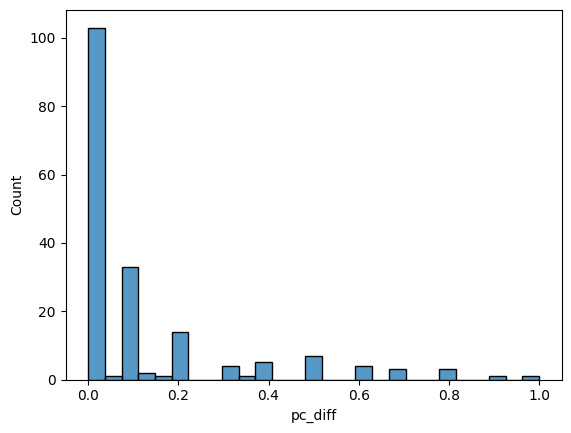

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(res_df[res_df["model_id"] == "P"]["pc_diff"])
plt.show()

/var/folders/dx/pd9ycs4j6mdgyss58ywfr_pc0000gn/T/ipykernel_8304/2278319773.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(


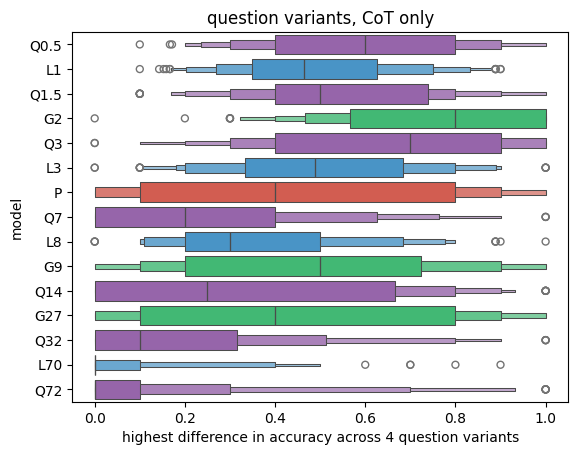

In [27]:
# Create a color mapping for each prefix
color_map = {
    "G": "#2ecc71",  # green
    "L": "#3498db",  # blue
    "Q": "#9b59b6",  # purple
    "P": "#e74c3c",  # red
}

# Create a list of colors based on the order
colors = [
    color_map[model_id[0]]
    for model_id in [
        "Q0.5",
        "L1",
        "Q1.5",
        "G2",
        "Q3",
        "L3",
        "P",
        "Q7",
        "L8",
        "G9",
        "Q14",
        "G27",
        "Q32",
        "L70",
        "Q72",
    ]
]

sns.boxenplot(
    y="model_id",
    x="pc_diff",
    data=res_df,
    orient="h",
    order=[
        "Q0.5",
        "L1",
        "Q1.5",
        "G2",
        "Q3",
        "L3",
        "P",
        "Q7",
        "L8",
        "G9",
        "Q14",
        "G27",
        "Q32",
        "L70",
        "Q72",
    ],
    palette=colors,
)
plt.xlabel("highest difference in accuracy across 4 question variants")
plt.ylabel("model")
plt.title("question variants, CoT only")
plt.show()

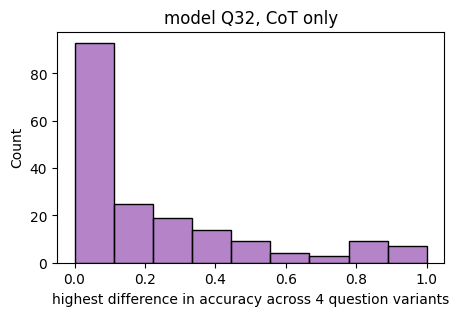

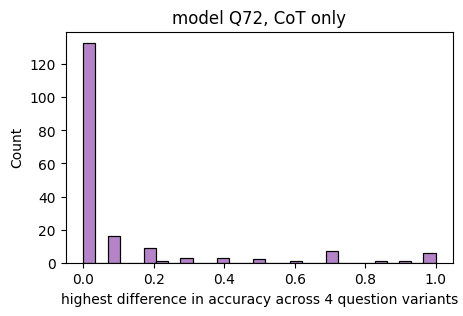

In [9]:
models = ["Q32", "Q72"]
# models = MODELS_MAP.keys()
for model in models:
    plt.figure(figsize=(5, 3))
    sns.histplot(
        res_df[res_df["model_id"] == model]["pc_diff"], color=color_map[model[0]]
    )
    plt.title(f"model {model}, CoT only")
    plt.xlabel("highest difference in accuracy across 4 question variants")
    plt.show()

In [10]:
res_df[(res_df["model_id"] == "G27") & (res_df["pc_diff"] > 0.5)][
    ["min_q_str", "min_pc"]
]

,min_q_str,min_pc
366,Did the Boeing 737 make its first flight after...,0.1
368,Did the P-51 Mustang make its first flight aft...,0.4
372,Did the Boeing 777 make its first flight after...,0.3
374,Did the Airbus A320 make its first flight afte...,0.0
375,Did the Spitfire make its first flight after t...,0.0
...,...,...
542,Does sodium have a lower atomic number than ox...,0.4
543,Does silicon have a higher atomic number than ...,0.2
545,Does phosphorus have a higher atomic number th...,0.4
547,Does lead have a lower atomic number than merc...,0.0


In [6]:
# First filter for mode == "cot"
df_cot = df[df["mode"] == "cot"]

# Group by the matching columns we care about
grouped = df_cot.groupby(["prop_id", "model_id", "instr_id"])


def find_pairs(group: pd.DataFrame) -> pd.DataFrame:
    pairs = []
    # Keep track of original indices
    for idx1, r1 in group.iterrows():
        for idx2, r2 in group.iloc[group.index.get_indexer([idx1])[0] + 1 :].iterrows():
            is_valid_pair = (
                (
                    r1["comparison"] == r2["comparison"]
                    and r1["answer"] != r2["answer"]
                    and r1["x_name"] == r2["y_name"]
                    and r1["y_name"] == r2["x_name"]
                )
                or (
                    r1["comparison"] != r2["comparison"]
                    and r1["answer"] == r2["answer"]
                    and r1["x_name"] == r2["y_name"]
                    and r1["y_name"] == r2["x_name"]
                )
                or (
                    r1["comparison"] != r2["comparison"]
                    and r1["answer"] != r2["answer"]
                    and r1["x_name"] == r2["x_name"]
                    and r1["y_name"] == r2["y_name"]
                )
            )

            if is_valid_pair:
                pairs.append((idx1, idx2))

    return pd.DataFrame(pairs)


# Apply the function to each group and combine results
paired_records = pd.concat([find_pairs(group) for _, group in grouped])

print(f"Found {len(paired_records)} matching pairs")

Found 21345 matching pairs


In [7]:
paired_records.iloc[0]

idx1                                                    3434
idx2                                                    7936
record1    {'q_str': 'Is Boeing 737-800 faster than Airbu...
record2    {'q_str': 'Is Airbus A380 faster than Boeing 7...
Name: 0, dtype: object